## Tarea 2, parte 2: Exoplanetas transitantes con Kepler



Entre los datos obtenidos por Kepler estan las curvas de luz donde el flujo observado varía durante el transito de un planeta alrededor de su estrella. A partir de esta curva de luz podemos obtener propiedades físicas de la estrella y del planeta. 

Por ejemplo, podemos extraer:
- La relación entre los radios del planeta y de la estrella $R_p/R_*$ a través de la   comparación entre flujos antes y durante el tránsito.
- El parámetro de impacto $b$ que define la posición angular por la que el planeta inicia su transito. 
- El parámetro $a/R_*$ donde $a$ es el semieje mayor de la orbita del planeta y $R_*$ el radio de la estrella. Esto nos da una medida relativa de la distancia del planeta con respecto a su estrella.
- El parámetro $\rho_* / \rho_{\odot}$ que indica la razón entre la densidad de la estrella con la densidad del Sol.

Referencia : [Seager & Mallén-Ornelas 2002](http://arxiv.org/pdf/astro-ph/0206228v1.pdf)

In [1]:
import batman
import numpy as np
import kplr
import matplotlib.pyplot as plt
import scipy.signal as sg
import itertools
% matplotlib inline

In [2]:
client = kplr.API()
koi = client.koi(1274.01)
lcs = koi.get_light_curves()

In [3]:
# Extrae los datos
def extract (inf_star):
    time, flux, ferr = [], [], []
    for lc in inf_star:
        with lc.open() as f:
            hdu_data = f[1].data
            time.append(hdu_data["time"])
            flux.append(hdu_data["pdcsap_flux"])
            ferr.append(hdu_data["pdcsap_flux_err"]) 
    return time,flux,ferr 

# Borra los nans
def del_nans (X1,X2,X3):  
    for m in range(len(X1)):
        t1, t2, t3 = X1[m], X2[m], X3[m]
        mask = np.array([not l for l in np.isnan(t1)])
        t1, t2, t3 = t1[mask], t2[mask], t3[mask]
        mask = np.array([not l for l in np.isnan(t2)])
        t1, t2, t3 = t1[mask], t2[mask], t3[mask]
        mask = np.array([not l for l in np.isnan(t3)])
        t1, t2, t3 = t1[mask], t2[mask], t3[mask]
        X1[m], X2[m], X3[m] = t1, t2, t3
    return X1, X2, X3

# Une los datos
def concatenate ():
    t, f, df = time[0], flux[0], ferr[0]
    for i in range(1, len(time)):
        t = np.concatenate ((t, time[i]))
        f = np.concatenate ((f, flux[i]))
        df = np.concatenate ((df, ferr[i]))
    return t, f, df 

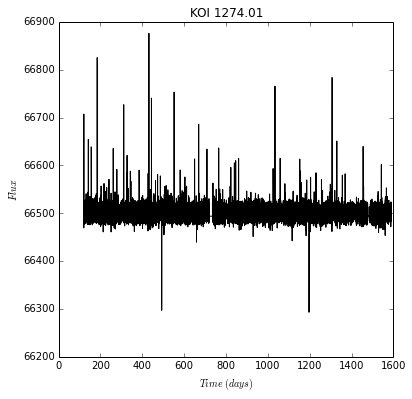

In [4]:
time, flux, ferr = extract(lcs)   
time, flux, ferr = del_nans (time, flux, ferr)

# Ajuste de acuerdo a offset
fl = 66500
for i,j in zip(time, flux):
    med = np.median(j)
    offy = fl - med 
    j += offy 
    
time, flux, ferr = concatenate ()
f, ax = plt.subplots(figsize = [6,6])
ax.plot(time,flux,'k-')
ax.set(xlabel = '$Time \ (days)$', ylabel = '$Flux$', title = 'KOI 1274.01')

In [5]:
median_filter = sg.medfilt(flux, 401)  # Correción a grandes escalas
flux_norm = flux / median_filter       # Normalización
filterdat = sg.medfilt(flux_norm, 15)  # Corrección a pequeña escala
flux_err = ferr / median_filter        # Normalización a errores

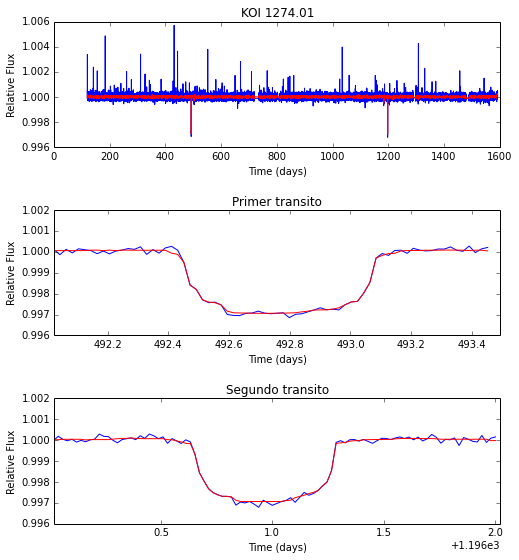

In [6]:
# Parametros para hacer zoom a los tránsitos
t1, t2, t3, t4 = 16690, 16760,48206,48300
f1, f2 = 0.996, 1.002

# Plot de curva completa y los dos tránsitos. En azul la normalización y en rojo el ajuste
# a pequeñas escalas.
f, (ax1,ax2,ax3) = plt.subplots(3, figsize = [8,9])
ax1.plot(time,flux_norm,'b-')
ax1.plot(time,filterdat,'r-')
ax1.set(xlabel = 'Time (days)', ylabel = 'Relative Flux', title = 'KOI 1274.01')

ax2.plot(time[t1:t2], flux_norm[t1:t2],'b')
ax2.plot(time[t1:t2], filterdat[t1:t2],'r')
ax2.set(xlim = (time[t1],time[t2]), ylim = (f1,f2), xlabel = 'Time (days)', 
        ylabel = 'Relative Flux', title = 'Primer transito' )

ax3.plot(time[t3:t4], flux_norm[t3:t4],'b')
ax3.plot(time[t3:t4], filterdat[t3:t4],'r')
ax3.set(xlim = (time[t3],time[t4]), ylim = (f1,f2), xlabel = 'Time (days)', 
        ylabel = 'Relative Flux', title = 'Segundo transito' )

f.subplots_adjust(hspace=0.5)

Usando estos gráficos podemos extraer los parámetros observables:

$\Delta F$: La diferencia de flujo antes y durante el tránsito (flujo normalizado a 1). 

$t_T$: Tiempo de tránsito.

$t_F$: Tiempo de tránsito durante la zona plana.

$P$: Periodo

A partir de estos observables podemos obtener los 4 parámetros mencionados al inicio usando las siguiente ecuaciones:

$\frac{R_p}{R_*} = \sqrt{\Delta F}  \\$

$ b = \left[\frac{(1-\sqrt{\Delta F})^2 -     \frac{\sin^2 \frac{t_F \pi}{P}}{\sin^2 \frac{t_T\pi}{P}}      (1+\sqrt{\Delta F})^2 }{1-  \frac{\sin^2 \frac{t_F \pi}{P}}{\sin^2 \frac{t_T\pi}{P}}} \right]^{1/2} \\ $

$\frac{a}{R_*}= \left[ \frac{(1+\sqrt{\Delta F})^2 -b^2 (1-\sin^2\frac{t_T \pi}{P})}{\sin^2 \frac{t_T\pi}{P}} \right]^{1/2}  \\$

$\frac{\rho_*}{\rho_{\odot}} = \frac{M_*/M_{\odot}}{(R_*/R_{\odot})^3} = \left[ \frac{4\pi^2}{P^2G} \right] \frac{a}{R_*}$


 (0.996, 1.001),
 (0.698625527915127, 0.70112552791512694),

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


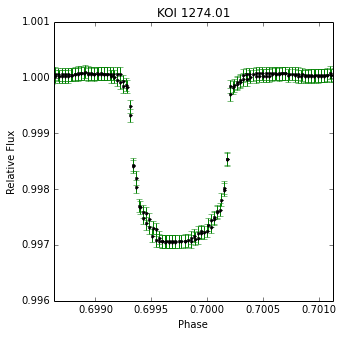

In [7]:
# Plot de Curva 'faseada' con sus errores
P = 704.2 # Periodo
phase = (time / P) % 1
p_min = phase[np.argmin(filterdat)]

f, ax = plt.subplots(figsize = [5,5])
ax.errorbar(phase, filterdat,flux_err, fmt ='k.', ecolor = 'green')
ax.set(ylim = (f1,1.001), xlim = (p_min-.001, p_min +.0015),
       xlabel = 'Phase', ylabel = 'Relative Flux', 
       title = 'KOI 1274.01')

**Curva de tránsito teórica y ajuste de batman**

Haremos el ajuste sobre el seundo tránsito. Primero, ajustaremos un spline sobre los puntos de observación medidos durante el tránsito; este spline será nuestra curva teórica a la cual le ajustaremos un curva generada por lo parámetros de entrada de batman. El mejor ajuste lo determinaremos mediante el procedimiento de mínimos cuadrados.


In [8]:
# Función que calcula los 4 y el ángulo de inclinación
def parameters (dF, tT, tF):
    
    R_p = np.sqrt(dF)
    ss1 = np.sin(tF * np.pi/P)**2
    ss2 = np.sin(tT * np.pi/P)**2
    b = np.sqrt( ((1-R_p)**2 - (ss1/ss2)*(1+R_p)**2) / (1-ss1/ss2))
    a = np.sqrt( ((1+R_p)**2 - (b**2)*(1-ss2)) / ss2 ) 
    rho = ((365.25**2) / ((P**2) * (215**3)))*a**3
    i = np.arccos(a**(-1) * b ) * 180/np.pi
    return R_p, b, a, rho, i

# Estimación de observables
tF = 0.49     # Tiempo de tránsito zona plana(días)
tT = 0.776    # Tiempo de tránsito total (días)
dF = 0.003    # Diferencia de flujo

rp, b, a, rho, i = parameters (dF, tT, tF)
print 'rp: ',rp
print 'b: ',b
print 'a: ', a
print 'rho: ', rho

rp:  0.0547722557505
b:  0.864969650689
a:  174.366538053
rho:  0.143503489895


El primer resultado nos indica que el radio del planeta es un 5.4% del radio de su estrella. A modo de comparación, el radio de Júpiter es un 10% el radio del Sol. Por lo tanto, podemos deducir que el planeta es de un tamaño considerable (más grande que la tierra) o bien, la estrella es relativamente pequeña.

Por otro lado, el parámetro de impacto indica que el tránsito ocurre cerca del borde de la estrella y no en el centro. La magnitud de este valor determina el valor de $t_T$ (y de $t_F$); un valor bajo de b implicaría tránsitos de mayor duración.

La densidad de la estrella es el 14% de la del Sol lo que implicaría un volumen mayor y por lo tanto un radio mayor. 

In [9]:
from scipy.interpolate import interp1d

mask = (time >= 1195.5) & (time <= 1198.5)                  # Analizaremos el segundo tránsito
t, flux, ferr = time[mask], filterdat[mask], flux_err[mask] # Extremos los datos correspondientes
t_min = t[np.argmin(flux)]                                  # Ubicamos la posicón del flujo mínimo
ti, tf = t.min(), t.max()                                   # Tiempo inicial y final

spl = interp1d(t, flux, kind='linear')                      # Interpolación lineal de los datos

In [10]:
import batman
from scipy.optimize import least_squares

def superman (t, dF, tT, tF, t0, u1, u2):
    rp, b, a, rho, i = parameters(dF,tT,tF)
    
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = t0                        #time of inferior conjunction
    params.per = P                        #orbital period
    params.rp = rp                        #planet radius (in units of stellar radii)
    params.a = a                          #semi-major axis (in units of stellar radii)
    params.inc = i                        #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.u = [u1, u2]                   #limb darkening coefficients
    params.limb_dark = "quadratic"        #limb darkening model
    
    m = batman.TransitModel(params, t)    #initializes model
    f = m.light_curve(params)
    bat_spl =  interp1d(t,f)
    return bat_spl(t)
                           
# Métrica
def err (param, t):
    dF, tT, tF, t0, u1, u2 = param
    return (spl(t) - superman(t,dF,tT,tF,t0,u1,u2))**2

# Guess
x0 = [dF, tT, tF, t_min, 0.3, 0.3]
# Constraints
lo = [dF-10, 0.0, 0.0, t_min-1, -2.0, -2.0]
hi = [dF+10, tT+10, tF+10, t_min+1, 5.0, 5.0]

times = np.linspace(ti, tf , 10000)
result = least_squares(err, x0, args=(times,) ,bounds=(lo, hi), verbose=2)
# (En este bloque usé la estructura que aparece en la pauta de la tarea 1.2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.7568e-10                                    5.27e-06    
       1              2         5.7786e-11      4.18e-10       1.63e-01       4.35e-07    
       2              3         8.7205e-12      4.91e-11       6.41e-02       9.21e-08    
       3              4         2.5812e-12      6.14e-12       1.27e-01       1.80e-07    
       4              5         4.5780e-13      2.12e-12       2.56e-02       3.36e-09    
`gtol` termination condition is satisfied.
Function evaluations 5, initial cost 4.7568e-10, final cost 4.5780e-13, first-order optimality 3.36e-09.


In [11]:
dF, tT, tF, t_min, u1, u2 = result.x
rp, b, a, rho, i = parameters (dF, tT, tF)

#Finalmente imprimimos los parametros obtenidos por la minimización
print 'Planet Radius: %.3f \t' %rp 
print 'Impact Parameter: %.3f \t' %b 
print 'Semi Major Axis: %.3f \t' %a 
print 'Star Density: %.3f \t' %rho 

Planet Radius: 0.054 	
Impact Parameter: 0.720 	
Semi Major Axis: 244.442 	
Star Density: 0.395 	


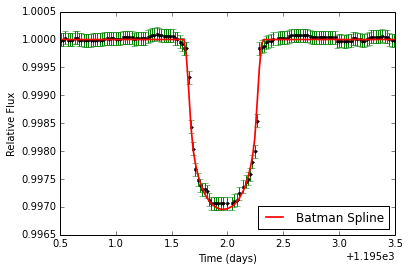

In [12]:
#Plot con el ajuste de batman
batman_spl = superman(t, dF, tT, tF, t_min, u1, u2)
plt.errorbar(t, flux, ferr, fmt='k.', ecolor = 'green')
plt.plot(t, batman_spl, 'r-', lw = 1.7, label = 'Batman Spline')
plt.xlabel('Time (days)')
plt.ylabel('Relative Flux')
plt.legend(loc='lower right',frameon=True, prop={'size':12})